<a href="https://colab.research.google.com/github/jjhurtadoa/Modelos-/blob/main/SER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Modelo para reconocer emociones por medio de la voz. Se obtienen fragmentos etiquetados de diferentes sets de datos, variando emociones y con voces masculinas y femeninas

# Leer archivos desde Kaggle

Primeramente necesitamos leer los archivos desde Kaggle, para hacer esto Kaggle nos provee de una clave en forma de Json. Corremos los comandos necesarios para tener acceso a los datos. Descargamos los datos y luego los descomprimimos. 

In [ ]:
!pip install -U kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"juanjosehurtado","key":"b22c794e7579fcf4388a8ab3707093d5"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

 97% 417M/429M [00:09<00:00, 38.2MB/s]
100% 429M/429M [00:09<00:00, 49.4MB/s]


In [ ]:
!kaggle datasets download -d ejlok1/cremad

 98% 441M/451M [00:08<00:00, 76.0MB/s]
100% 451M/451M [00:08<00:00, 54.0MB/s]


In [ ]:
!kaggle datasets download -d ejlok1/surrey-audiovisual-expressed-emotion-savee

 98% 105M/107M [00:02<00:00, 45.4MB/s] 
100% 107M/107M [00:02<00:00, 54.5MB/s]


In [ ]:
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess

 97% 417M/428M [00:10<00:00, 38.1MB/s]
100% 428M/428M [00:10<00:00, 42.5MB/s]


In [ ]:
!unzip -q ravdess-emotional-speech-audio.zip -d .

In [ ]:
!unzip -q cremad.zip -d .

In [ ]:
!unzip -q surrey-audiovisual-expressed-emotion-savee.zip -d .

In [ ]:
!unzip -q toronto-emotional-speech-set-tess.zip -d .

# Importar Librerías y creación del dataset

Importamos las libreráis necesarias para todas las etapas del modelo

In [ ]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Creamos un dataframe con los audios obtenidos de  Ravdess (Ryerson Audio-Visual Database of Emotional Speech and Song) 

In [ ]:
Ravdess= "/content/audio_speech_actors_01-24"

In [ ]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []

for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + '/'+dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + '/'+ dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])


# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()



Emotions                                               Path
0  surprise  /content/audio_speech_actors_01-24/Actor_07/03...
1      calm  /content/audio_speech_actors_01-24/Actor_07/03...
2   disgust  /content/audio_speech_actors_01-24/Actor_07/03...
3  surprise  /content/audio_speech_actors_01-24/Actor_07/03...
4      fear  /content/audio_speech_actors_01-24/Actor_07/03...

Creamos un dataframe con los audios obtenidos de  Crema Dataset (Crowd-sourced Emotional Multimodal Actors Dataset)

In [ ]:
Crema='/content/AudioWAV'

In [ ]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + '/'+ file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                   Path
0      sad  /content/AudioWAV/1043_ITS_SAD_XX.wav
1    angry  /content/AudioWAV/1059_TAI_ANG_XX.wav
2      sad  /content/AudioWAV/1002_DFA_SAD_XX.wav
3  neutral  /content/AudioWAV/1068_DFA_NEU_XX.wav
4     fear  /content/AudioWAV/1015_IWL_FEA_XX.wav

Creamos un dataframe con los audios obtenidos de  TESS (Toronto emotional speech set)

In [ ]:
Tess= '/content/TESS Toronto emotional speech set data'

In [ ]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + '/'+ dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + '/'+ dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

Emotions                                               Path
0  neutral  /content/TESS Toronto emotional speech set dat...
1  neutral  /content/TESS Toronto emotional speech set dat...
2  neutral  /content/TESS Toronto emotional speech set dat...
3  neutral  /content/TESS Toronto emotional speech set dat...
4  neutral  /content/TESS Toronto emotional speech set dat...

Creamos un dataframe con los audios obtenidos de SAVEE (Surrey Audio-Visual Expressed Emotion)

In [ ]:
Savee= '/content/ALL'

In [ ]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + '/'+file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions                      Path
0      fear   /content/ALL/JE_f03.wav
1   neutral   /content/ALL/KL_n13.wav
2      fear   /content/ALL/JE_f09.wav
3  surprise  /content/ALL/DC_su07.wav
4   neutral   /content/ALL/DC_n14.wav

# Exploración de datos


Concatenamos los dataframe que se han generado para tener solo uno.

In [ ]:
# creating Dataframe using all the 4 dataframes we created so far.
df = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
df.to_csv("df.csv",index=False)
df.head()

Emotions                                               Path
0  surprise  /content/audio_speech_actors_01-24/Actor_07/03...
1      calm  /content/audio_speech_actors_01-24/Actor_07/03...
2   disgust  /content/audio_speech_actors_01-24/Actor_07/03...
3  surprise  /content/audio_speech_actors_01-24/Actor_07/03...
4      fear  /content/audio_speech_actors_01-24/Actor_07/03...

Con ayuda de la librería librosa, se crean diagramas de las ondas y espectogramas que es una representación visual de las variaciones de la frecuencia en el eje vertical, y de la intensidad del sonido mediante niveles de colores a lo largo del tiempo que se representa en el eje horizontal.

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

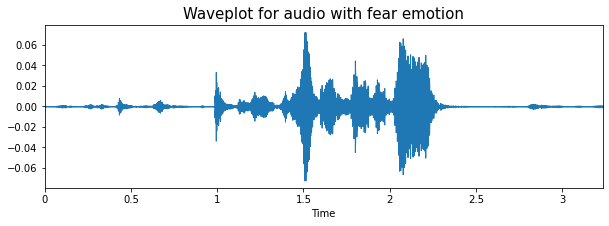

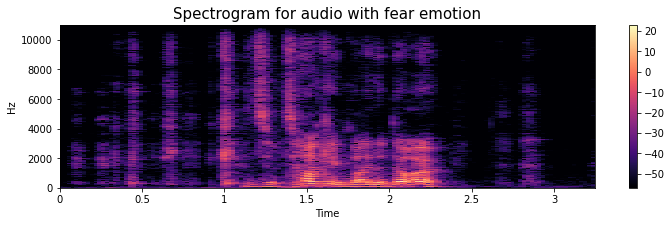

In [ ]:
emotion='fear'
path = np.array(df.Path[df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

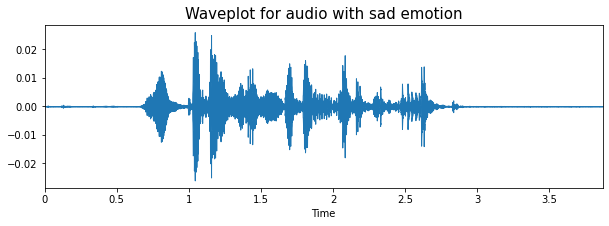

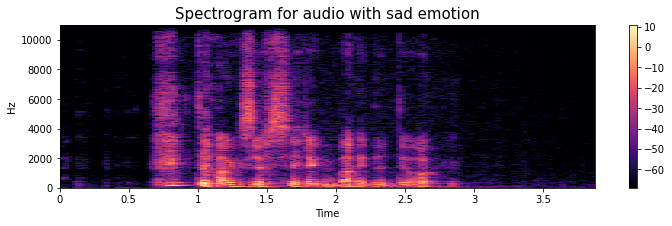

In [ ]:
emotion='sad'
path = np.array(df.Path[df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

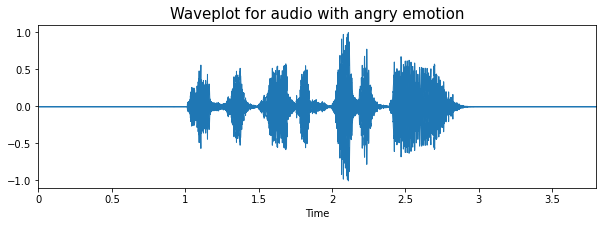

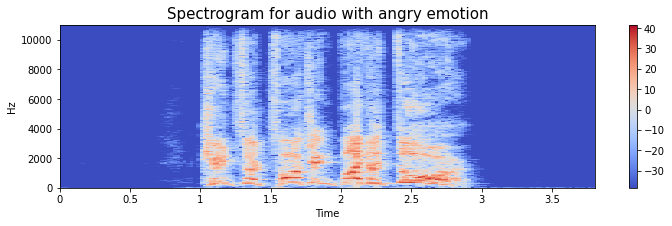

In [ ]:
emotion='angry'
path = np.array(df.Path[df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

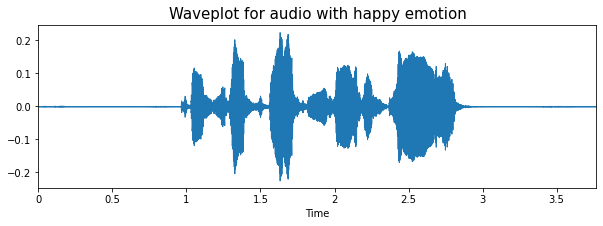

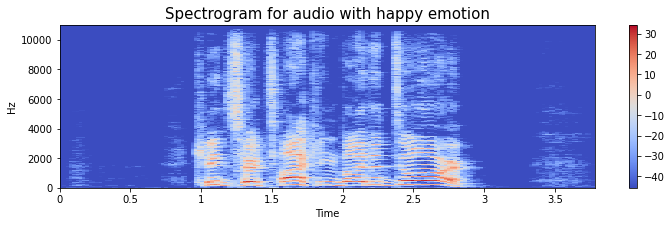

In [ ]:
emotion='happy'
path = np.array(df.Path[df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

Para aumentar nuestro set de datos, crearemos datos sintéticos adicionando perturbaciones en nuestros datos originales. <br>
Noise: Se agrega ruido uniforme al audio <br>
Stretch: Se cambia la velocidad del audio <br> 
Shift: Cambia el audio hacia la derecha o izquierda aleatoriamente <br>
Pitch: Cambia la intensidad del sonido aleatoriamente<br>

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(df.Path)[1]
data, sample_rate = librosa.load(path)

Algunos ejemplos de los audios perturbados

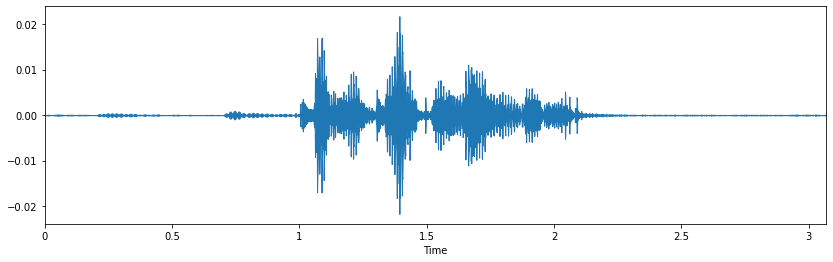

In [ ]:
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data, sr=sample_rate)
Audio(path)

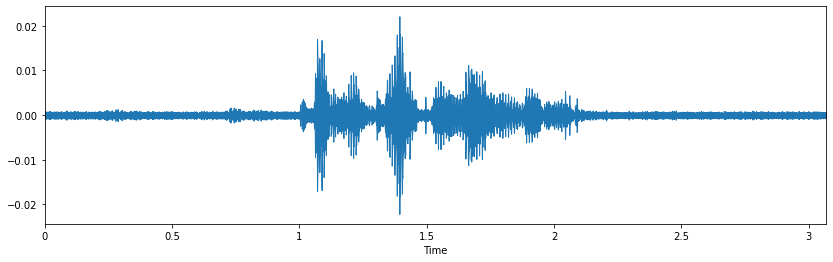

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

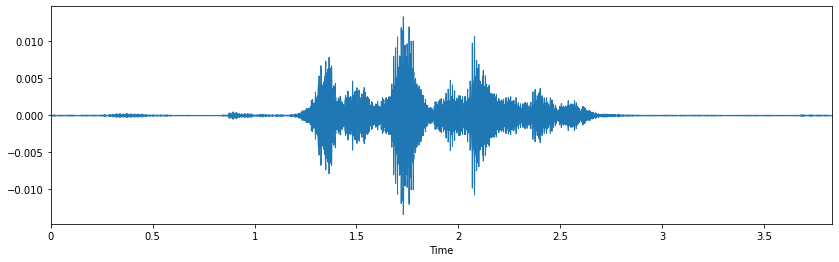

In [ ]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

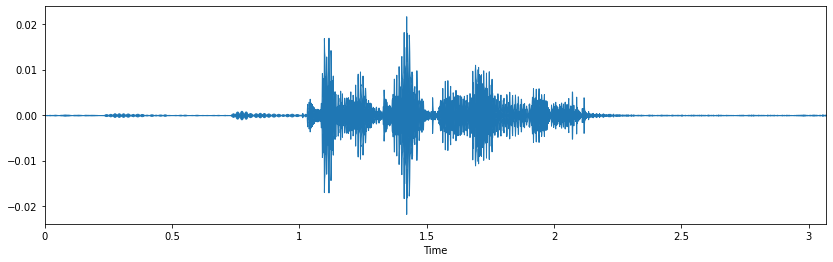

In [ ]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

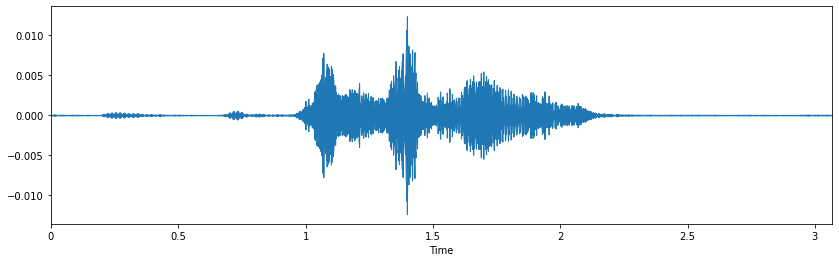

In [ ]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

Para llevar a cabo el análisis  se extraerán características relevantes de los archivos de audio <br>
ZCR (Zero Crosing Rate) = La tasa de cambios de signo de la señal durante la duración de un frame  <br> 
Chroma =  Representación de la energía espectral <br> 
Mfcc = Los coeficientes cepstrales de frecuencia mel forman una representación cepstral en la que las bandas de frecuencia no son lineales, sino que se distribuyen según la escala mel. <br> 
Mel= es una escala musical perceptual de tonos juzgados como intervalos equiespaciados por parte de observadores.

Se le extraerán estas características al set de datos original, a los datos con ruidos  y a los datos perturbados con streching y pitching, teniendo un conjunto de datos 3 veces mayor y menos propenso al overfitting.


In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [ ]:
X, Y = [], []
for path, emotion in zip(df.Path, df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [ ]:
len(X), len(Y), df.Path.shape

(36486, 36486, (12162,))

Se crea un dataframe con las características extraidas, la última columna de este dataframe es la emoción asociada a estas características.

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
#Features.to_csv('features.csv', index=False)
Features.head()

0         1         2  ...           160           161    labels
0  0.135588  0.574426  0.646772  ...  2.070440e-03  1.339037e-04     angry
1  0.243973  0.667299  0.719729  ...  4.123381e-03  2.123920e-03     angry
2  0.162793  0.559973  0.616600  ...  5.068693e-04  3.597619e-05     angry
3  0.216984  0.788837  0.812607  ...  1.327277e-07  6.788799e-09  surprise
4  0.333601  0.840134  0.857432  ...  1.583674e-05  1.449936e-05  surprise

[5 rows x 163 columns]

Los datos se han guardado en un archivo para no hacer la extracción de características cada que queramos correr el modelo

In [ ]:
from google.colab import files
files.upload()

Saving features.csv to features.csv


In [ ]:
Features= pd.read_csv('/content/features.csv')
Features.head()

0         1         2  ...           160           161    labels
0  0.135588  0.574426  0.646772  ...  2.070440e-03  1.339037e-04     angry
1  0.243973  0.667299  0.719729  ...  4.123381e-03  2.123920e-03     angry
2  0.162793  0.559973  0.616600  ...  5.068693e-04  3.597619e-05     angry
3  0.216984  0.788837  0.812607  ...  1.327277e-07  6.788799e-09  surprise
4  0.333601  0.840134  0.857432  ...  1.583674e-05  1.449936e-05  surprise

[5 rows x 163 columns]

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values


# Creación del modelo

Utilizamos el encoder para las etiquetas. Particionamos los datos, y acomodamos el tamaño para hacerlo compatible con el modelo




In [ ]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162, 1), (27364, 8), (9122, 162, 1), (9122, 8))

Se crea un modelo secuencial con 8 capas convolucionales.

In [ ]:
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(x_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(8)) # Target class number
model.add(Activation('softmax'))
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# opt = keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 162, 256)          2304      
_________________________________________________________________
activation (Activation)      (None, 162, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 162, 256)          524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 162, 256)          1024      
_________________________________________________________________
activation_1 (Activation)    (None, 162, 256)          0         
_________________________________________________________________
dropout (Dropout)            (None, 162, 256)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 256)          

Entrenamos el modelo reduciendo el learning rate cuando la pérdida ha dejado de mejorar 

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
428/428 [==============================] - 49s 40ms/step - loss: 1.6799 - accuracy: 0.3207 - val_loss: 1.5529 - val_accuracy: 0.3771
Epoch 2/50
428/428 [==============================] - 17s 39ms/step - loss: 1.4355 - accuracy: 0.4295 - val_loss: 1.6718 - val_accuracy: 0.3450
Epoch 3/50
428/428 [==============================] - 17s 39ms/step - loss: 1.3232 - accuracy: 0.4735 - val_loss: 1.8064 - val_accuracy: 0.3499
Epoch 4/50
428/428 [==============================] - 17s 39ms/step - loss: 1.2720 - accuracy: 0.4932 - val_loss: 1.6783 - val_accuracy: 0.3756
Epoch 5/50
428/428 [==============================] - 17s 39ms/step - loss: 1.2291 - accuracy: 0.5078 - val_loss: 1.9106 - val_accuracy: 0.3456
Epoch 6/50
428/428 [==============================] - 17s 39ms/step - loss: 1.1946 - accuracy: 0.5194 - val_loss: 1.7084 - val_accuracy: 0.3805
Epoch 7/50
428/428 [==============================] - 17s 39ms/step - loss: 1.1702 - accuracy: 0.5287 - val_loss: 1.8175 - val_accuracy:

Evaluamos el modelo con los datos seleccionados para test

286/286 [==============================] - 3s 10ms/step - loss: 1.1472 - accuracy: 0.5936
Accuracy of our model on test data :  59.361982345581055 %


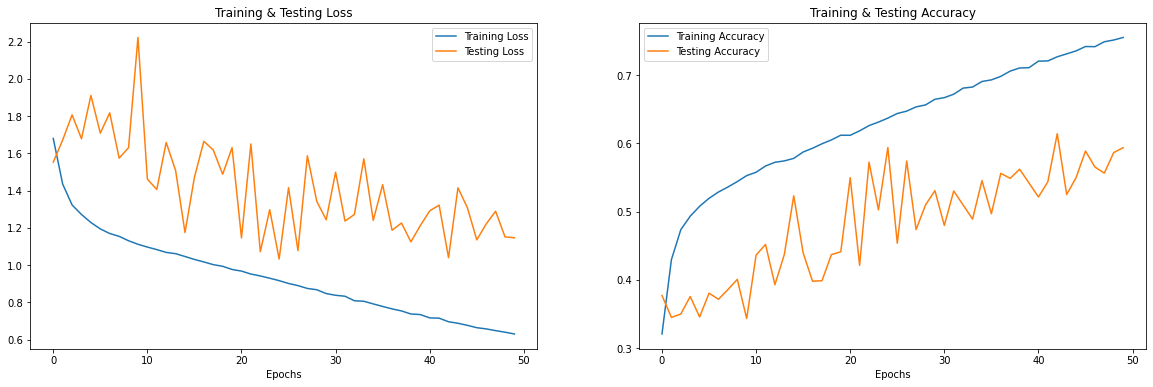

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

Podemos ver que el modelo no tiene una exactitud muy alta, pero vemos que aprende. 

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0            angry         happy
1         surprise      surprise
2              sad           sad
3            angry         angry
4          neutral       neutral
5            happy         happy
6         surprise           sad
7          neutral       neutral
8          neutral          fear
9              sad           sad

En la matriz de confusión se puede ver que el desbalanceo de datos puede estar afectando el performance del modelo

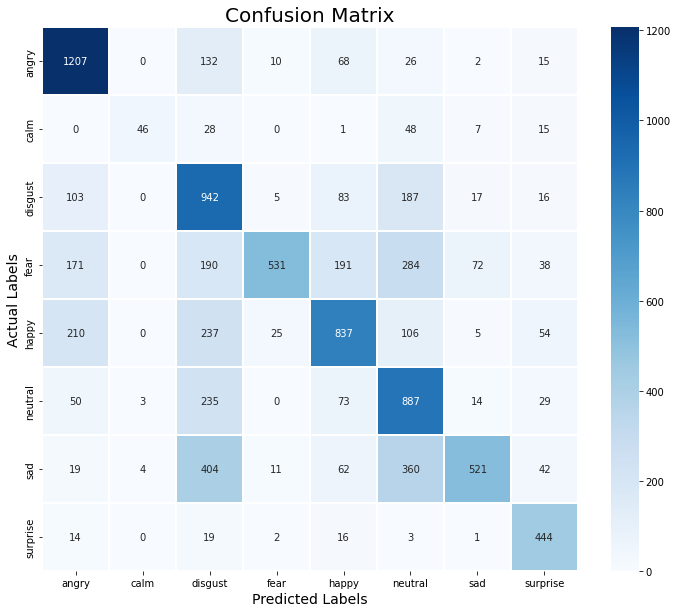

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

# Cambiando el dataframe

Podemos ver que los datos están desbalanceados, intentaremos desarrollar el modelo eliminando la sorpresa y la calma

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


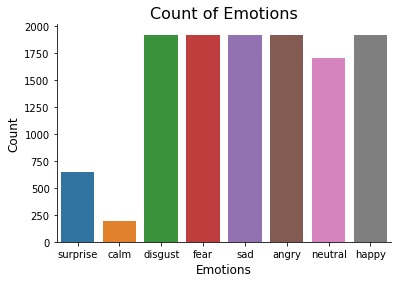

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
df2= df
df2.head()

Emotions                                               Path
0  surprise  /content/audio_speech_actors_01-24/Actor_07/03...
1      calm  /content/audio_speech_actors_01-24/Actor_07/03...
2   disgust  /content/audio_speech_actors_01-24/Actor_07/03...
3  surprise  /content/audio_speech_actors_01-24/Actor_07/03...
4      fear  /content/audio_speech_actors_01-24/Actor_07/03...

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


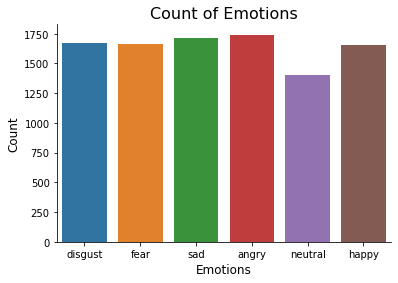

In [ ]:
df2= df2.drop(df2[df2.Emotions == 'surprise'].index)
df2= df2.drop(df2[df2.Emotions == 'calm'].index)
plt.title('Count of Emotions', size=16)
sns.countplot(df2.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
X, Y = [], []
for path, emotion in zip(df2.Path, df2.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features2.csv', index=False)
Features.head()

0         1         2  ...       160           161   labels
0  0.232553  0.769210  0.743217  ...  0.000018  1.553830e-06  disgust
1  0.294063  0.799261  0.791335  ...  0.000037  1.981294e-05  disgust
2  0.162822  0.730021  0.744741  ...  0.000002  1.776294e-07  disgust
3  0.178064  0.571985  0.549052  ...  0.000010  6.382350e-07     fear
4  0.229858  0.618974  0.623205  ...  0.000018  7.610976e-06     fear

[5 rows x 163 columns]

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values


# Creación del modelo

Utilizamos el encoder para las etiquetas. Particionamos los datos, y acomodamos el tamaño para hacerlo compatible con el modelo




In [ ]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((22149, 162), (22149, 6), (7383, 162), (7383, 6))

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((22149, 162, 1), (22149, 6), (7383, 162, 1), (7383, 6))

Se crea un modelo secuencial con 8 capas convolucionales.

In [ ]:
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(x_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(6)) # Target class number
model.add(Activation('softmax'))
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# opt = keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 162, 256)          2304      
_________________________________________________________________
activation_9 (Activation)    (None, 162, 256)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 162, 256)          524544    
_________________________________________________________________
batch_normalization_2 (Batch (None, 162, 256)          1024      
_________________________________________________________________
activation_10 (Activation)   (None, 162, 256)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 162, 256)          0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 20, 256)          

Entrenamos el modelo reduciendo el learning rate cuando la pérdida ha dejado de mejorar 

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
347/347 [==============================] - 46s 41ms/step - loss: 1.5678 - accuracy: 0.3406 - val_loss: 1.8594 - val_accuracy: 0.2342
Epoch 2/50
347/347 [==============================] - 13s 38ms/step - loss: 1.4470 - accuracy: 0.4042 - val_loss: 1.4448 - val_accuracy: 0.3914
Epoch 3/50
347/347 [==============================] - 13s 38ms/step - loss: 1.3728 - accuracy: 0.4409 - val_loss: 1.5329 - val_accuracy: 0.3600
Epoch 4/50
347/347 [==============================] - 13s 38ms/step - loss: 1.2970 - accuracy: 0.4787 - val_loss: 1.4276 - val_accuracy: 0.4103
Epoch 5/50
347/347 [==============================] - 13s 38ms/step - loss: 1.2431 - accuracy: 0.4956 - val_loss: 1.2838 - val_accuracy: 0.4863
Epoch 6/50
347/347 [==============================] - 13s 38ms/step - loss: 1.2017 - accuracy: 0.5122 - val_loss: 1.3768 - val_accuracy: 0.4030
Epoch 7/50
347/347 [==============================] - 13s 38ms/step - loss: 1.1675 - accuracy: 0.5281 - val_loss: 1.2174 - val_accuracy:

Evaluamos el modelo con los datos seleccionados para test

231/231 [==============================] - 2s 9ms/step - loss: 1.1410 - accuracy: 0.5816
Accuracy of our model on test data :  58.1606388092041 %


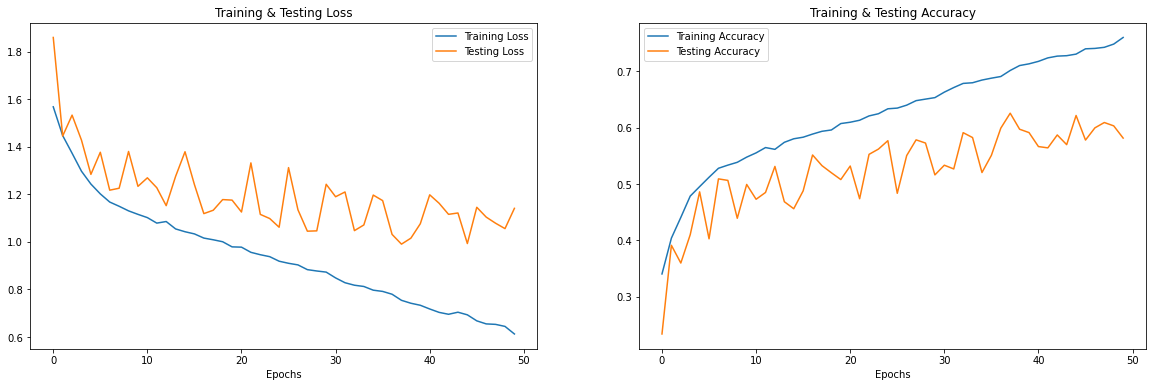

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

Podemos ver que el modelo no tiene una exactitud muy alta, pero vemos que aprende. 

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0          disgust          fear
1            happy          fear
2          disgust       disgust
3          disgust       disgust
4          neutral           sad
5            happy         angry
6            happy       disgust
7          disgust       disgust
8          disgust         happy
9          disgust       disgust

En la matriz de confusión se puede ver que el desbalanceo de datos puede estar afectando el performance del modelo

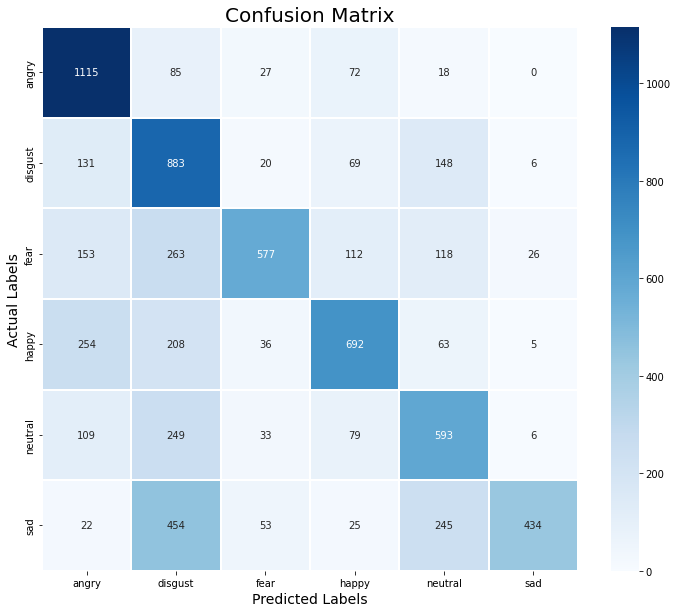

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       angry       0.62      0.85      0.72      1317
     disgust       0.41      0.70      0.52      1257
        fear       0.77      0.46      0.58      1249
       happy       0.66      0.55      0.60      1258
     neutral       0.50      0.55      0.53      1069
         sad       0.91      0.35      0.51      1233

    accuracy                           0.58      7383
   macro avg       0.65      0.58      0.58      7383
weighted avg       0.65      0.58      0.58      7383

